### Object and Instance Segmentation

In [78]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import math
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, Conv2DTranspose
import pix2pix
from IPython.display import clear_output

In [36]:
flowers_builder = tfds.builder("oxford_flowers102")
flowers_builder.download_and_prepare()

print(flowers_builder.info)

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=0.0.1,
    description='
The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1030 images each).
The test set consist of the remaining 6129 images (minimum 20 per class).
',
    urls=['https://www.robots.ox.ac.uk/~vgg/data/flowers/102/'],
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=81

In [37]:
flowers_builder.info.features

FeaturesDict({
    'file_name': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
})

In [38]:
print(flowers_builder.info.features["label"].names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101']


In [108]:
# Some hyper-parameters:
batch_size  = 64            # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 20           # Max number of training epochs
random_seed = 42            # Seed for some random operations, for reproducibility
scale_factor = 4            # Upscale factor
# resize_shape = (500, 525, 3) # resize the input images to this shape

# Train/val Datasets:
train_dataset = flowers_builder.as_dataset(split=tfds.Split.TRAIN)
val_dataset = flowers_builder.as_dataset(split=tfds.Split.TEST)

# Number of classes:
num_classes = flowers_builder.info.features['label'].num_classes

# Number of images:
num_train_imgs = flowers_builder.info.splits['train'].num_examples
num_val_imgs = flowers_builder.info.splits['test'].num_examples

train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)



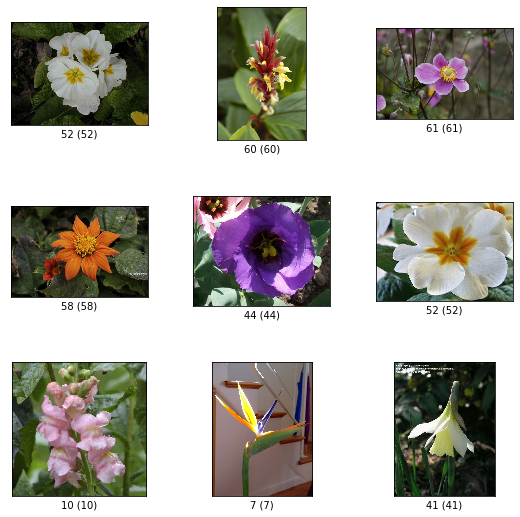

In [109]:
fig = tfds.show_examples(flowers_builder.info, train_dataset)

In [163]:
TRAIN_LENGTH = flowers_builder.info.splits['train'].num_examples
TEST_LENGTH = flowers_builder.info.splits['test'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 4
TRAIN_STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_STEPS_PER_EPOCH = TEST_LENGTH // BATCH_SIZE

In [111]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)

    input_image = normalize(input_image)

    return input_image

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))

    input_image = normalize(input_image)

    return input_image

In [112]:
train = train_dataset.map(load_image_train, num_parallel_calls=4)
test = val_dataset.map(load_image_test)

In [113]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [114]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [115]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [116]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [117]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

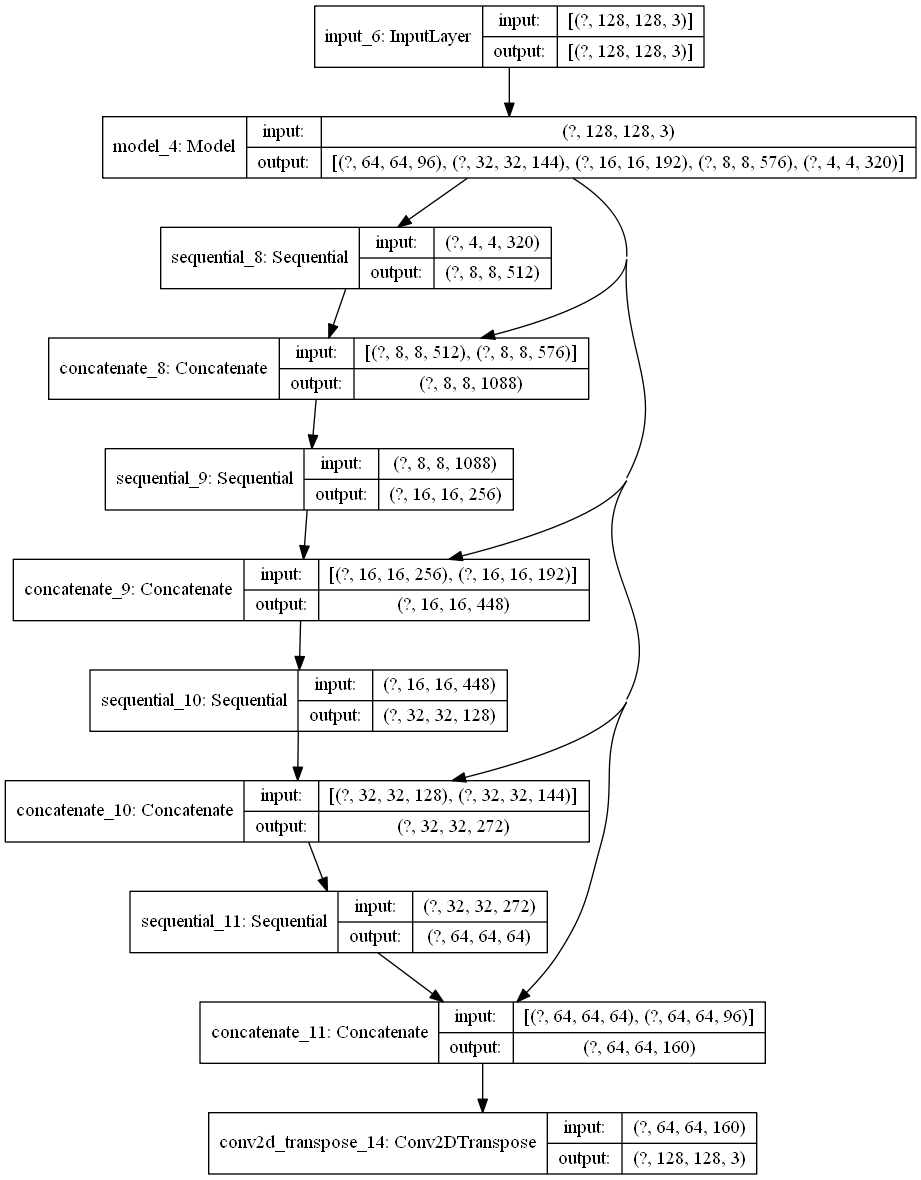

In [118]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [119]:
def display(display_list):
    plt.figure(figsize=(5, 5))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

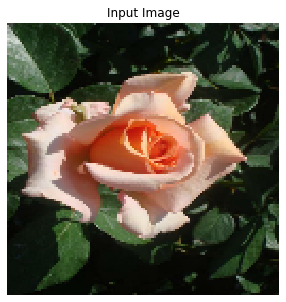

In [120]:
for image in train.take(1):
    sample_image = image
display([sample_image])

In [121]:
def create_mask(pred_mask):
    print('pred')
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for image in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], create_mask(pred_mask)])
    else:
        display([sample_image, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [122]:
pred = model.predict(sample_image[tf.newaxis, ...])

pred


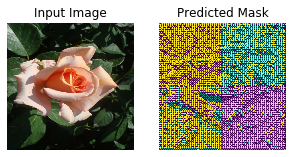

In [125]:
show_predictions()

In [126]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
history = autoencoder.fit_generator(
    train_generator, steps_per_epoch=train_steps_per_epoch, epochs=num_epochs,
    validation_data=val_generator, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

pred


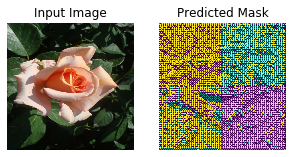


Sample Prediction after epoch 1

 1/15 [=>............................] - ETA: 6s

IndexError: tuple index out of range

In [165]:
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = flowers_builder.info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
                          validation_steps=VAL_STEPS_PER_EPOCH,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [168]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Model)                 [(None, 64, 64, 96), 1841984     input_6[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 8, 8, 512)    1476608     model_4[1][4]                    
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 8, 8, 1088)   0           sequential_8[0][0]               
                                                                 model_4[1][3]              